In [3]:
import pandas as pd
from scipy.spatial import KDTree
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pickle
from matplotlib import cm
from math import sin, cos, sqrt, atan2, radians
import matplotlib.dates as mdates
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# define all helper functions for the data

# function to define the hurricane score
def wind_speed(distance, v_m, r_m):
    b = 2
    x = 0
    s = 0.5
   
    x = ((r_m/distance)**b)*np.exp(1-(r_m/distance)**b)

    return v_m*x**s

# def wind_speed(distance, v_m, r_m):
    # solve v_m*x**s = 17.5
    # x**s = 17.5 / v_m
    # slog(x) = log(17.5 / v_m)
    # s = log (17.5 / v_m) / log(x)
    r_175 = 1.5 * v_m / 0.5144
    b = 2
    x = 0
    s = 0
    if (distance <= r_m):
        s = 0.5
    else:
        s = np.log(17.5 / v_m) / np.log(((r_m/r_175)**b)*np.exp(1-(r_m/r_175)**b))
    x = ((r_m/distance)**b)*np.exp(1-(r_m/distance)**b)

    return v_m*x**s


# function to calculate distance using lat, lon (distance in km)
def distance(loc1, loc2):
    # Approximate radius of earth in km
    R = 6373.0

    lat1 = radians(loc1[0])
    lon1 = radians(loc1[1])
    lat2 = radians(loc2[0])
    lon2 = radians(loc2[1])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c

    return distance

# define set of functions to predict Rmax8
def calc_f(lat):
    return 2*.00007292*sin(radians(lat))

def calc_mratio(v_max, r_175, lat):
    return 0.699 * np.exp(-0.00618*(v_max - 17.5)-0.00210*(v_max - 17.5)*(1/2*calc_f(lat)*r_175))

def calc_m175(r_175, lat):
    return r_175 * 17.5 + 1/2 * calc_f(lat)*r_175**2

def calc_rmax(v_max, lat):
    r_175 = 1.8 * v_max / 0.5144
    # r_175 = 100*1.61 # distance converted from nautical miles to kilometers
    # r_175 = 60 # distance converted from nautical miles to kilometers

    
    return v_max/(calc_f(lat))*(sqrt(1+2*calc_f(lat)*(calc_m175(r_175, lat)*calc_mratio(v_max, r_175, lat))/(v_max**2))-1)


BD1: ['1', '7']
[1, 7]
[datetime.datetime(2017, 8, 17, 15, 0), datetime.datetime(2017, 8, 17, 21, 0), datetime.datetime(2017, 8, 18, 3, 0), datetime.datetime(2017, 8, 18, 9, 0), datetime.datetime(2017, 8, 18, 15, 0), datetime.datetime(2017, 8, 18, 21, 0), datetime.datetime(2017, 8, 19, 3, 0), datetime.datetime(2017, 8, 19, 9, 0), datetime.datetime(2017, 8, 19, 15, 0), datetime.datetime(2017, 8, 19, 21, 0), datetime.datetime(2017, 8, 20, 3, 0), datetime.datetime(2017, 8, 23, 15, 0), datetime.datetime(2017, 8, 23, 21, 0), datetime.datetime(2017, 8, 24, 3, 0), datetime.datetime(2017, 8, 24, 9, 0), datetime.datetime(2017, 8, 24, 15, 0), datetime.datetime(2017, 8, 24, 18, 0), datetime.datetime(2017, 8, 24, 21, 0), datetime.datetime(2017, 8, 25, 3, 0), datetime.datetime(2017, 8, 25, 9, 0), datetime.datetime(2017, 8, 25, 15, 0), datetime.datetime(2017, 8, 25, 21, 0), datetime.datetime(2017, 8, 26, 3, 0), datetime.datetime(2017, 8, 26, 9, 0), datetime.datetime(2017, 8, 26, 15, 0), datetime.dat

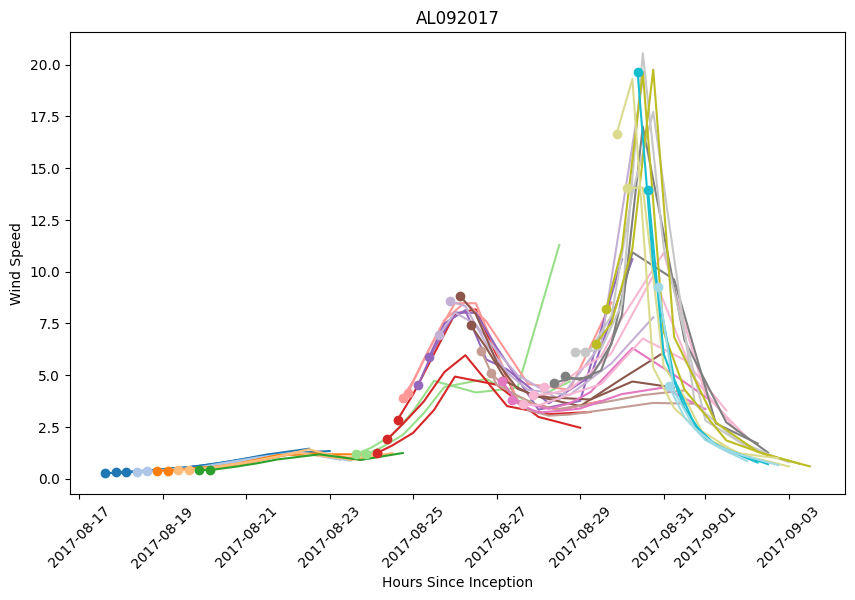

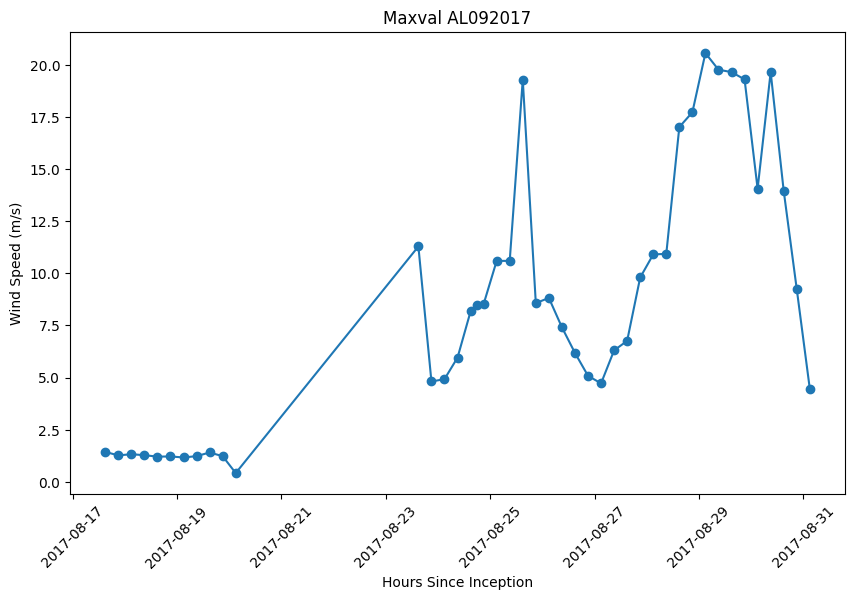

8
2017


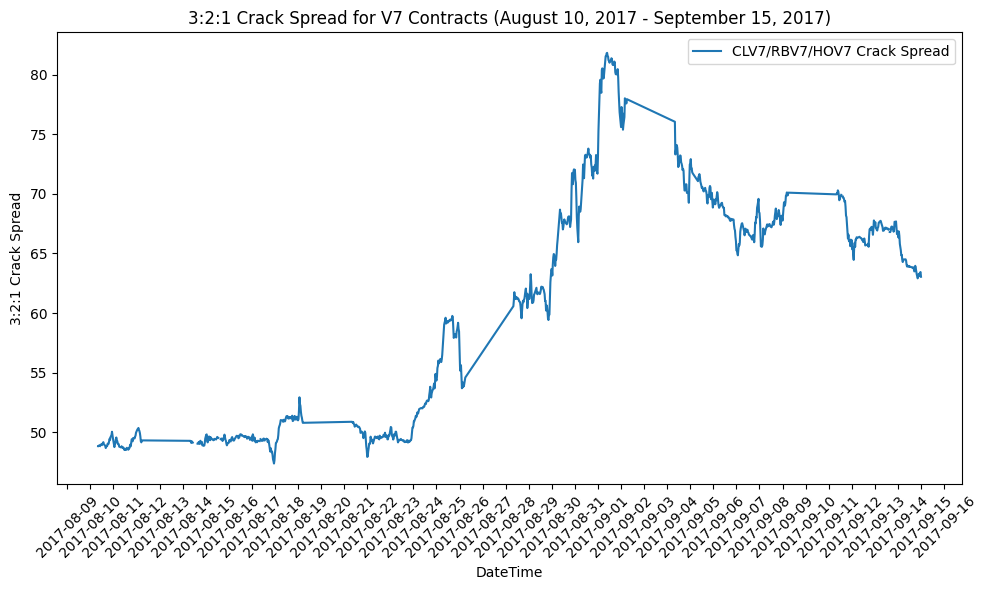

ADF Statistic: -1.3197313194953582
p-value: 0.6200975650030945
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


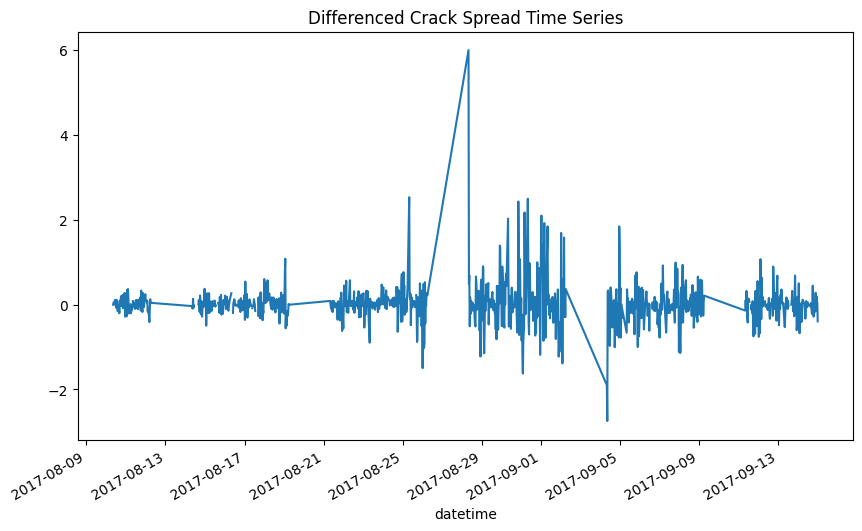

ADF Statistic (Differenced Data): -26.31633307022755
p-value (Differenced Data): 0.0
Critical Values (Differenced Data):
	1%: -3.436
	5%: -2.864
	10%: -2.568


In [9]:
# storms = ['AL092017', 'AL142021', 'AL222020', 'AL132020', 'AL142020', 'AL032017'] # harvey, nicholas, beta, laura, marco, cindy
storms = ['AL092017'] # harvey
# storms = ['AL022019', 'AL032020', 'AL082020', 'AL192020', 'AL262020', 'AL282020'] # Hurricane Barry, Tropical Storm Cristobal, Hurricane Hanna, Hurricane Sally, Hurricane Delta, Hurricane Zeta
# storms = ['AL162017', 'AL092012', 'AL042012'] # Hurricane Nate, Hurricane Isaac, Tropical Storm Debby
# storms = ['AL092017', 'AL132020', 'AL192020', 'AL082020', 'AL142020', 'AL032017', 'AL142021', 'AL222020']  # PA Storms
# storms = ['AL022019', 'AL162017', 'AL092012', 'AL042012','AL032020', 'AL262020', 'AL282020'] # GV Storms
# storms = ['AL262020']

# storms = ['AL092017', 'AL132020', 'AL192020'] # good port arthur storms
# storms = ['AL092012', 'AL022019', 'AL162017', 'AL032020']


houston = np.array([29.7604, -95.3698]) # define the lat lon values for houston
galveston = ([29.3013, -94.7977]) # define the lat lon values for galveston
port_arthur = np.array([29.8850, -93.9399]) # define lat long values for port arthur
baton_rouge = ([30.4515, -91.1871]) # define lat long values for baton rouge
pca = ([0.80449481, -0.52853266, -0.2710006])
garyville = np.array([30.057346, -90.618488]) # define the lat lon values for garyville
midpoint = (port_arthur + garyville) / 2

cit = garyville

def phillips_perron_test(series):
    pp_test = sm.tsa.stattools.adfuller(series, regression='ct', autolag='AIC')
    pp_output = pd.Series(pp_test[0:4], index=['Test Statistic', 'p-value', 'Lags Used', 'Number of Observations Used'])
    for key, value in pp_test[4].items():
        pp_output[f'Critical Value ({key})'] = value
    return pp_output


def wind(storm, city):

    ## extract the month from financial data, since it is not stored in the track data
    file_path = f'Intraday_data/{storm}.csv'
    data = pd.read_csv(file_path)
    
    date_string = data.iloc[1]['date']
    parsed_date = datetime.strptime(date_string, "%Y-%m-%d")
    storm_month = parsed_date.month # the storm's initial month
    storm_day = parsed_date.day # the storm's initial day
    storm_year = int(storm[-4:])

    with open(f"Data/{storm_year}data.pkl", 'rb') as f:
        x = pickle.load(f)

    # Initialize storm inception time
    inception_time_str = x[storm]['1']['INIT']['Time (UTC)']
    inception_day = int(inception_time_str[:2])
    inception_hour = 0 # updated later
    inception_time = datetime(storm_year, storm_month, inception_day, inception_hour)

    # set up the figure for each storm
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.title(f"{storm}")
    plt.xlabel("Hours Since Inception")
    plt.ylabel("Wind Speed")

    day_count = 0
    prev28 = 0
    prev29 = 0
    prev30 = 0
    prev31 = 0
    base_day = list(x[storm]['1']['INIT']['Time (UTC)'])[0:2]
    print("BD1:", base_day)
    base_day = [int(base_day[0]), int(base_day[1])]
    print(base_day)
    max_harr = []
    t_release = []

    # iterate through each discussion (forecast)
    for i, key in enumerate(x[storm].keys()):
        times = [] # temporary until I have final formula for the threat score
        wind_speeds = []
        lat_arr = []
        lon_arr = []
        hscore_arr = []
        datetimes = []  # Store datetime objects
        max_hs = 0

        # iterate through each line in a discussion
        for j, key2 in enumerate(x[storm][key].keys()):
        
            # print(key, key2) # for debugging

            # only add if storm is not dissipated
            if (x[storm][key][key2]['Dissipated?'] != True):

                # extract lat/lon strings
                lat = x[storm][key][key2]['Latitude']
                lon = x[storm][key][key2]['Longitude']
                ws_temp = x[storm][key][key2]['Wind Speed (KT)']   
                
                time_string = list(x[storm][key][key2]['Time (UTC)'])

                current_day = [int(time_string[0]), int(time_string[1])]
                add31 = 0

                # check if the date ever crosses the month border, and if it does, then store what the previous day was
                if ((current_day[0] - base_day[0])*10 + (current_day[1] - base_day[1])) < 0:
                    if prev_day == [3,1]:
                        prev31 = 1
                    elif prev_day == [3,0]:
                        prev30 = 1
                    elif prev_day == [2,9]:
                        prev29 = 1
                    elif prev_day == [2,8]:
                        prev28 = 1
                    
                    # calculating the total number of hours past the initial date
                    adds = prev28 * 28 + prev29 * 29 + prev30 * 30 + prev31 * 31
                    day_hrs = ((current_day[0] - base_day[0])*10 + (current_day[1] - base_day[1]) + adds)* 24
                    hour = int(time_string[3]) * 10 + int(time_string[4]) + day_hrs
    
                    # Extract time and convert to datetime
                    current_datetime = inception_time + timedelta(hours=hour)
                    times.append(current_datetime)

                # if the date doesn't cross a month border, continue as usual
                else:
                    day_hrs = ((current_day[0] - base_day[0])*10 + (current_day[1] - base_day[1]))* 24
                    hour = int(time_string[3]) * 10 + int(time_string[4]) + day_hrs

                    # Extract time and convert to datetime
                    current_datetime = inception_time + timedelta(hours=hour)
                    times.append(current_datetime)
            
                # append the wind speed in knots to the wind speed array
                wind_speeds.append(int(ws_temp))

                # get the location of the storm
                if (lat[-1] == "N"):
                    lat_arr.append(float(lat[0:-1]))
                elif (lat[-1] == "S"):
                    lat_arr.append(-float(lat[0:-1]))
                if (lon[-1] == "E"):
                    lon_arr.append(float(lon[0:-1]))
                elif (lon[-1] == "W"):
                    lon_arr.append(-float(lon[0:-1]))

                # # define the storm that we are interested in analyzing [now defined in function]
                # city = port_arthur

                # calculate distance from city to the storm
                dist1 = distance(garyville, np.array([lat_arr[-1], lon_arr[-1]])) #
                # calculate distance from city to the storm
                dist2 = distance(port_arthur, np.array([lat_arr[-1], lon_arr[-1]])) #
                # calculate distance from city to the storm
                dist = np.min(np.array([dist1, dist2]))

                # # calculate distance from city to the storm
                # dist = distance(city, np.array([lat_arr[-1], lon_arr[-1]]))

                windspeed_ms = int(ws_temp) * 0.5144

                # append the wind speed in the city to the forecast's array, based on the equations of the wind field model from above
                hscore_arr.append(wind_speed(dist, windspeed_ms, calc_rmax(windspeed_ms, lat_arr[-1])))

                # store the max wind speed in a given forecast
                if ((hscore_arr[-1] > max_hs)& (j <= 100)):
                    max_hs = hscore_arr[-1]

                # go to the next day
                prev_day = current_day
        
        # append the max wind speed after each forecast
        max_harr.append(max_hs)

        # append the initial release time for each forecast
        t_release.append(times[0])
    
        
        colormap = cm.tab20
        color = colormap(i / len(x[storm]))


        # plotting the forecasts
        ax.plot(times[0], hscore_arr[0], marker = "o", color = color)
        ax.plot(times, hscore_arr, color=color, label = key)    
        

    print(t_release)
    plt.xticks(rotation=45) 
    plt.show()

    
    fig2, ax2 = plt.subplots(figsize=(10, 6))
    plt.title(f"Maxval {storm}")
    plt.xlabel("Hours Since Inception")
    plt.ylabel("Wind Speed (m/s)")
    ax2.plot(t_release, max_harr, marker = "o")

    # Rotate x-axis labels
    plt.xticks(rotation=45)

    plt.show()

    return t_release, max_harr

def crack(storm):

    file_path = f'Intraday_data/{storm}.csv'
    data = pd.read_csv(file_path)

    # Beginning of the Data
    date_string = data.iloc[1]['date']
    parsed_date = datetime.strptime(date_string, "%Y-%m-%d")
    storm_month = parsed_date.month # the storm's initial month
    storm_day = parsed_date.day # the storm's initial day
    storm_year = int(storm[-4:])
    print(storm_month)
    print(storm_year)

    # Convert date and time to a datetime format
    data['datetime'] = pd.to_datetime(data['date']) + timedelta(hours=13.5) + pd.to_timedelta(data['time'], unit='min') 

    # Convert HO and RB prices to per barrel
    data.loc[data['sym'].str.contains('HO') | data['sym'].str.contains('RB'), ['bid', 'ask', 'prc']] *= 42

    contract = data.iloc[-1]['sym'][2:]


    if (storm == 'AL132020') | (storm == 'AL142020'):
        contract = 'V0'

    if storm == 'AL032017':
        contract = 'Q7'

    if storm == 'AL022019':
        contract = 'N9'

    if (storm == 'AL032020'):
        contract = 'N0'
    if (storm == 'AL082020'):
        contract = 'Q0'

    if (storm == 'AL192020'):
        contract = 'V0'

    if (storm == 'AL262020'):
        contract = 'X0'
        
    if (storm == 'AL282020'):
        contract = 'Z0'

    if (storm == 'AL162017'):
        contract = 'X7'

    if (storm == 'AL092012'):
        contract = 'V2'
        
    if (storm == 'AL042012'):
        contract = 'Q2'
 
 
    ho = f'HO{contract}'
    rb = f'RB{contract}'
    cl = f'CL{contract}'

    
    date_final = data.iloc[-1]['date']
    parsed_date_final = datetime.strptime(date_final, "%Y-%m-%d")
    # print(parsed_date_final)
    final_month = parsed_date_final.month # the storm's initial month
    final_day = parsed_date_final.day # the storm's initial day
    final_year = parsed_date_final.year

    storm_year = int(storm[-4:])

    
    # Filter data for the desired date range and specific contracts
    start_date = datetime(storm_year, storm_month, storm_day)
    end_date = datetime(final_year,final_month, final_day)
    filtered_data = data[(data['datetime'] >= start_date) & (data['datetime'] <= end_date)]
    filtered_data = filtered_data[filtered_data['sym'].isin([cl, rb, ho])]
        

    # Pivot the data for easier calculation
    pivoted_data = filtered_data.pivot_table(index='datetime', columns='sym', values='prc')

    # Calculate the 3:2:1 crack spreads
    pivoted_data['321crack_spread'] = -1* ( 3 * pivoted_data[cl] - 2 * pivoted_data[rb] - pivoted_data[ho])

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(pivoted_data.index, pivoted_data['321crack_spread'], label=f'{cl}/{rb}/{ho} Crack Spread')

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator())
    plt.xticks(rotation=45)
    plt.xlabel('DateTime')
    plt.ylabel('3:2:1 Crack Spread')
    plt.title(f'3:2:1 Crack Spread for {contract} Contracts ({start_date.strftime("%B %d, %Y")} - {end_date.strftime("%B %d, %Y")})')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return pivoted_data

time_difference_threshold = 31  # 30 minutes, for example

# iterate through each storm in the 'storms' list above. This will be the loop that sets up the X and Y data for the regression
for storm in storms:

    t_release, max_harr = wind(storm, cit) ################################################################################ define city
    
    # Phase 2: Processing the Crack Spread Data
    
    pivoted_data = crack(storm)

    # Initialize lists for regression variables
    wind_speeds, current_crack_spreads, lagged_crack_spreads = [], [], []

    # pivoted_data['321crack_spread'].plot(figsize=(10, 6))
    # plt.title('Intraday Crack Spread Time Series')
    # plt.show()


    # Conduct the Augmented Dickey-Fuller test
    adf_result = adfuller(pivoted_data['321crack_spread'].dropna())

    print('ADF Statistic:', adf_result[0])
    print('p-value:', adf_result[1])
    print('Critical Values:')
    for key, value in adf_result[4].items():
        print('\t%s: %.3f' % (key, value))

    # Differencing the data
    pivoted_data['differenced_crack_spread'] = pivoted_data['321crack_spread'].diff().dropna()

    # Plot the differenced data to visually inspect it
    pivoted_data['differenced_crack_spread'].plot(figsize=(10, 6))
    plt.title('Differenced Crack Spread Time Series')
    plt.show()

    adf_result_diff = adfuller(pivoted_data['differenced_crack_spread'].dropna())

    print('ADF Statistic (Differenced Data):', adf_result_diff[0])
    print('p-value (Differenced Data):', adf_result_diff[1])
    print('Critical Values (Differenced Data):')
    for key, value in adf_result_diff[4].items():
        print('\t%s: %.3f' % (key, value))







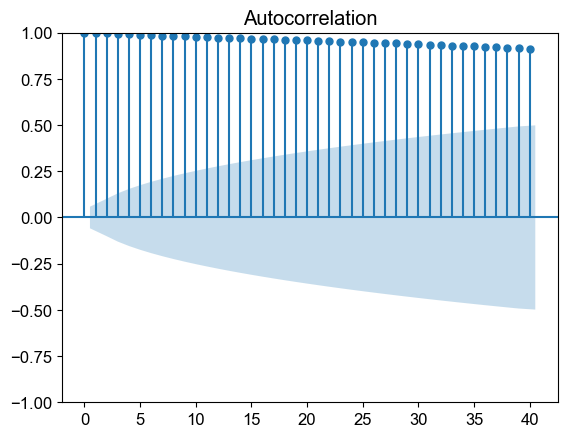

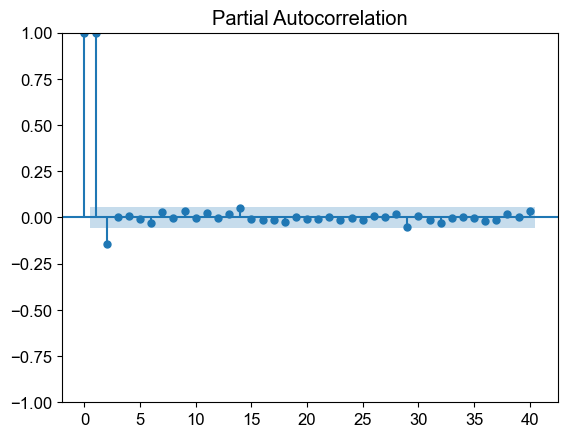

In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF
plot_acf(pivoted_data['321crack_spread'].dropna(), lags=40)
plot_pacf(pivoted_data['321crack_spread'].dropna(), lags=40)
plt.show()


In [15]:
from statsmodels.tsa.arima.model import ARIMA

p = 1
q = 1
# Replace p, d, q with your identified parameters
model = ARIMA(pivoted_data['321crack_spread'], order=(p, 1, q))
results = model.fit()

# Print out the summary of the model
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:        321crack_spread   No. Observations:                 1151
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -687.752
Date:                Mon, 08 Apr 2024   AIC                           1381.504
Time:                        16:49:43   BIC                           1396.647
Sample:                             0   HQIC                          1387.220
                               - 1151                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1288      0.097      1.323      0.186      -0.062       0.320
ma.L1          0.0900      0.098      0.920      0.358      -0.102       0.282
sigma2         0.1955      0.002     98.918      0.0

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


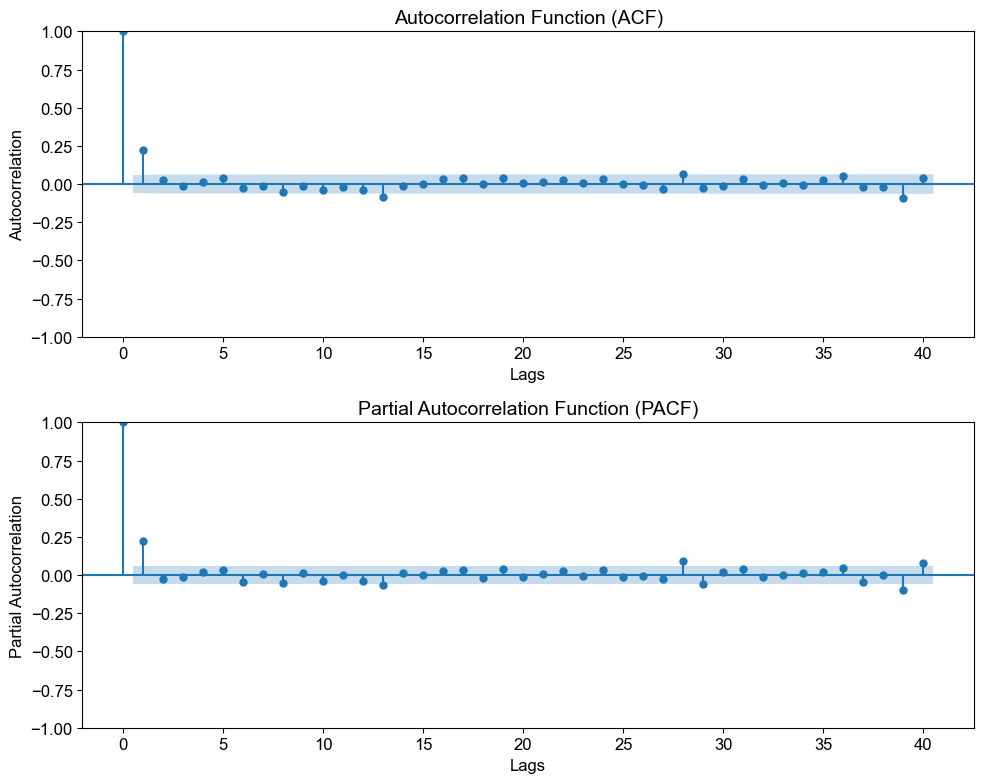

In [16]:
# Ensure the font size and style are set for a professional look
plt.rcParams.update({'font.size': 12, 'font.family': 'Arial'})

# Set the figure size for better readability
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# ACF plot
plot_acf(pivoted_data['differenced_crack_spread'].dropna(), ax=axes[0], lags=40)
axes[0].set_title('Autocorrelation Function (ACF)', fontsize=14)
axes[0].set_xlabel('Lags', fontsize=12)
axes[0].set_ylabel('Autocorrelation', fontsize=12)

# PACF plot
plot_pacf(pivoted_data['differenced_crack_spread'].dropna(), ax=axes[1], lags=40)
axes[1].set_title('Partial Autocorrelation Function (PACF)', fontsize=14)
axes[1].set_xlabel('Lags', fontsize=12)
axes[1].set_ylabel('Partial Autocorrelation', fontsize=12)

# Adjust layout for clarity
plt.tight_layout()
plt.show()